# AIM5004_HW3

* (Total 10 pts) Training a character-level language model with recurrent neural networks and Transformers architecture. You are going to write codes in python w/ whichever deep learning libraries you prefer to use, e.g. pytorch, tensorflow, keras, jax, mxnet, and so on.

 - - -

## Question - a

(a) Download shakespeare dataset from https://storage.googleapis.com/download.
tensorflow.org/data/shakespeare.txt. Report the number of unique characters
and this number will be the number of your vocabulary (note that ’a’ and ’A’ are
different characters). Also, show 3 random chunks (200 characters per each) of the
dataset.

In [1]:
import os
import random
import codecs
import string
import nltk
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
from collections import Counter

In [3]:
##Setting torch environment

if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device: ', DEVICE)

Using PyTorch version: 1.7.1  Device:  cuda


### Shakespeare text dataset

In [4]:
data_fpath = tf.keras.utils.get_file('shakespeare.txt','https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')
shakespeare = codecs.open(data_fpath, 'r', encoding='utf8').read()
data = shakespeare
data_len = len(data)
print(data_len)
print(data[:300]) ## including space

1115394
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us


### Vocabulary check

In [5]:
vocab = sorted(set(data))
vocab_size = len(vocab)

print('Vocabulary of the Shakespeare data: {}'.format(vocab))
print('The number of unique characters: {}'.format(vocab_size))

Vocabulary of the Shakespeare data: ['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
The number of unique characters: 65


In [6]:
char2idx = {u:i for i, u in enumerate(vocab)}         ## dictionary to create id for each vocab(character)
idx2char = np.array(vocab)                            ## numpy array for each vocab(character)
text_as_int = np.array([char2idx[c] for c in data])   ## convert text format into id format

print('Example of the original text: ', data[:13])
print('Example of the encoded text:  {}'.format(text_as_int[:13]))

Example of the original text:  First Citizen
Example of the encoded text:  [18 47 56 57 58  1 15 47 58 47 64 43 52]


### Random dataset chunks

In [7]:
chunk = 200

def random_select():
    stt = random.randint(0, data_len - chunk)
    end = stt + chunk + 1
    return data[stt : end]

In [8]:
print("First random Chunk: \n", random_select())

First random Chunk: 
 le in the street cry Romeo,
Some Juliet, and some Paris; and all run,
With open outcry toward our monument.

PRINCE:
What fear is this which startles in our ears?

First Watchman:
Sovereign, here lies 


In [9]:
print("Second random Chunk: \n", random_select())

Second random Chunk: 
 pled offices, untrodden stones?
And what hear there for welcome but my groans?
Therefore commend me; let him not come there,
To seek out sorrow that dwells every where.
Desolate, desolate, will I hence


In [10]:
print("Third random Chunk: \n", random_select())

Third random Chunk: 
  on to fight with us.

CLARENCE:
A little gale will soon disperse that cloud
And blow it to the source from whence it came:
The very beams will dry those vapours up,
For every cloud engenders not a sto


- - -

## Question - b

(b) Design a vanila RNN architecture and write the training codes w/ following hyperparameters. Report the number of model parameters.
(You can use RNN libararies, if you want, but I recommend you to implement by yourself.)
> (1) input embedding size: 64 \
(2) hidden size: 128 \
(3) the number of time steps (sequence length, or chunk length): 200 \
(4) the number of layers: 3 \
(5) activation function for hidden units: tanh \
(6) loss function: cross entropy loss \
(7) optimization algorithm: ADAM \
(8) batch size: 64 \
(9) training epochs: 30 \
(10) for other hyperparemeters, you are free to choose whatever you would like to use.

In [11]:
class Args:
    emb_size=64
    seq_size=200   ## chunk length
    lstm_size=64
    g_norm=5
    bs=64
    num_step=20
    epochs=30
    lr=0.001
    momentum = 0.9
    verbose='store_true'
    seed=710674

args = Args()    

np.random.seed(args.seed)
random.seed(args.seed)
torch.manual_seed(args.seed)

### Data preprocessing

In [12]:
## splitting document into words
def doc2words(doc):
    lines = doc.split('\n')
    lines = [line.strip(r'\"') for line in lines]
    words = ' '.join(lines).split()
    return words

In [13]:
## removing punctuations attached to words
def removepunct(words):
    punct = set(string.punctuation)
    words = [''.join([char for char in list(word) if char not in punct]) for word in words]
    return words

In [14]:
## get vocabulary from word list
def getvocab(words):
    wordfreq = Counter(words)
    sorted_wordfreq = sorted(wordfreq, key=wordfreq.get)
    return sorted_wordfreq

In [15]:
## get dictionary of int to words and word to int
def vocab_map(vocab):
    int_to_vocab = {k:w for k,w in enumerate(vocab)}
    vocab_to_int = {w:k for k,w in int_to_vocab.items()}
    return int_to_vocab, vocab_to_int

In [16]:
words = removepunct(doc2words(data))  ## remove punctuations and split the document into words
vocab = getvocab(words)
int_to_vocab, vocab_to_int = vocab_map(vocab)

In [17]:
print("sample words: ", words[:10])
print("sample vocab: ", vocab[:10])

sample words:  ['First', 'Citizen', 'Before', 'we', 'proceed', 'any', 'further', 'hear', 'me', 'speak']
sample vocab:  ['relieved', 'humanely', 'afflicts', 'inventory', 'particularise', 'rakes', 'commonalty', 'maliciously', 'softconscienced', 'altitude']


* Preparing batch set for the training process

In [18]:
def get_batches(words, vocab_to_int, batch_size, seq_size):
    # generate a Xs and Ys of shape (batchsize * num_batches) * seq_size
    word_ints = [vocab_to_int[word] for word in words]
    num_batches = int(len(word_ints) / (batch_size * seq_size))
    Xs = word_ints[:num_batches*batch_size*seq_size]
    Ys = np.zeros_like(Xs)
    Ys[:-1] = Xs[1:]
    Ys[-1] = Xs[0]
    Xs = np.reshape(Xs, (num_batches*batch_size, seq_size))
    Ys= np.reshape(Ys, (num_batches*batch_size, seq_size))
    
    # iterate over rows of Xs and Ys to generate batches
    for i in range(0, num_batches*batch_size, batch_size):
        yield Xs[i:i+batch_size, :], Ys[i:i+batch_size, :]

### RNN Model

In [19]:
class RNN_model(nn.Module):
    ## initialize RNN module
    def __init__(self, n_vocab, seq_size, emb_size, lstm_size):
        super(RNN_model, self).__init__()
        self.seq_size = seq_size
        self.lstm_size = lstm_size
        self.embedding = nn.Embedding(n_vocab, emb_size)
        self.lstm = nn.LSTM(emb_size, lstm_size, batch_first=True)
        self.dense = nn.Linear(lstm_size, n_vocab)
    
    
    ## forward path
    def forward(self, x, prev_state):
        embed = self.embedding(x)
        output, state = self.lstm(embed, prev_state)
        logits = self.dense(output)

        return logits, state
    
    def zero_state(self, batch_size):
        return (torch.zeros(1, batch_size, self.lstm_size),torch.zeros(1, batch_size, self.lstm_size))

* Criterion and optimizer settings

In [23]:
def cri_opti(net, lr):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=args.lr)
    return criterion, optimizer

* RNN model training

In [24]:
ppl = []
def train_rnn(words, vocab_to_int, int_to_vocab, n_vocab):
    
    ## RNN instance
    model = RNN_model(n_vocab, args.seq_size, args.emb_size, args.lstm_size)
    model = model.to(DEVICE)
    criterion, optimizer = cri_opti(model, lr=args.lr)

    iteration = 0
    
    for epoch in range(args.epochs):
        batches = get_batches(words, vocab_to_int, args.bs, args.seq_size)
        state_h, state_c = model.zero_state(args.bs)

        ## Transfer data to GPU
        state_h = state_h.to(DEVICE)
        state_c = state_c.to(DEVICE)
        
        for x, y in batches:
            iteration += 1

            ## Tell it we are in training mode
            model.train()

            ## Reset all gradients
            optimizer.zero_grad()

            ## Transfer data to GPU
            x = torch.tensor(x).to(DEVICE).long()
            y = torch.tensor(y).to(DEVICE).long()

            logits, (state_h, state_c) = model(x, (state_h, state_c))
            loss = criterion(logits.transpose(1, 2), y)

            state_h = state_h.detach()
            state_c = state_c.detach()

            loss_value = loss.item()
#             ppl.append(loss_value)

            ## backward
            loss.backward(retain_graph=True)
            _ = torch.nn.utils.clip_grad_norm_(model.parameters(), args.g_norm)
            
            # Update the network's parameters
            optimizer.step()

            if iteration % 10 == 0:
                print('Epoch: {}/{}'.format(epoch, args.epochs),'Iteration: {}'.format(iteration),'Loss: {}'.format(loss_value))
        ppl.append(loss_value)

    return model

- - -

## Question - c

(c) Perplexity is defined as the exponentiated average negative log-likelihood of a sequence. Let X = (x0, . . . , xt), then the perplexity of X is ...
> Train your network RNNs and provide a PPL curve over the course of the training.

### Training

* Training results

In [25]:
rnn_net = train_rnn(words, vocab_to_int, int_to_vocab, len(vocab))

Epoch: 0/30 Iteration: 10 Loss: 9.552824974060059
Epoch: 1/30 Iteration: 20 Loss: 9.418272972106934
Epoch: 1/30 Iteration: 30 Loss: 8.828167915344238
Epoch: 2/30 Iteration: 40 Loss: 7.833780288696289
Epoch: 3/30 Iteration: 50 Loss: 7.4333720207214355
Epoch: 3/30 Iteration: 60 Loss: 7.126779079437256
Epoch: 4/30 Iteration: 70 Loss: 7.080755233764648
Epoch: 5/30 Iteration: 80 Loss: 7.206726551055908
Epoch: 5/30 Iteration: 90 Loss: 7.034430980682373
Epoch: 6/30 Iteration: 100 Loss: 7.044061183929443
Epoch: 7/30 Iteration: 110 Loss: 7.178586006164551
Epoch: 7/30 Iteration: 120 Loss: 7.019559383392334
Epoch: 8/30 Iteration: 130 Loss: 7.0313239097595215
Epoch: 9/30 Iteration: 140 Loss: 7.162108898162842
Epoch: 9/30 Iteration: 150 Loss: 7.000847816467285
Epoch: 10/30 Iteration: 160 Loss: 7.017825126647949
Epoch: 11/30 Iteration: 170 Loss: 7.144163608551025
Epoch: 11/30 Iteration: 180 Loss: 6.979129791259766
Epoch: 12/30 Iteration: 190 Loss: 6.9999895095825195
Epoch: 13/30 Iteration: 200 Loss:

### Perplexity curve

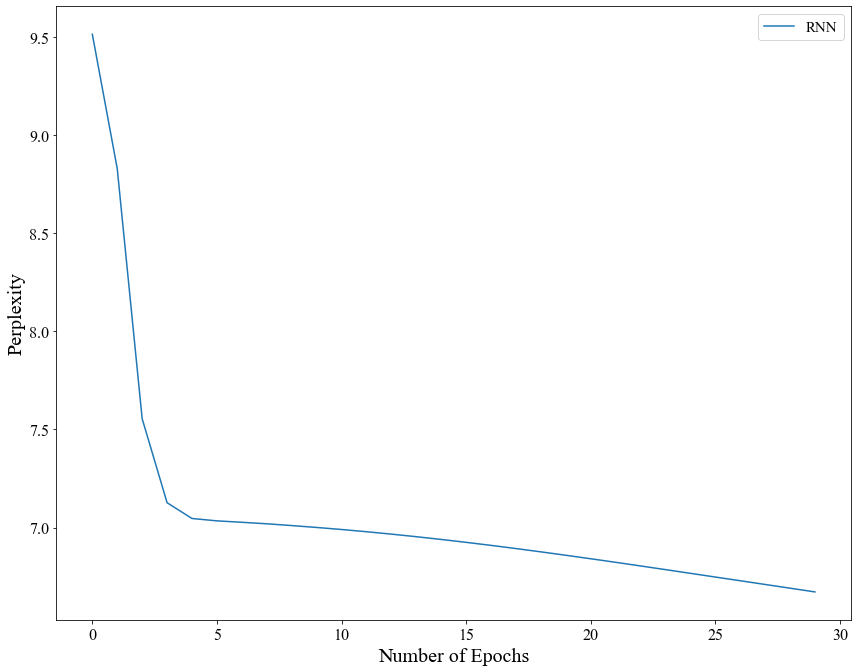

In [26]:
## Loss Graphs
plt.rc('font', family='Times New Roman', serif='Times')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('axes', labelsize=20)

fig, ax = plt.subplots()
fig.subplots_adjust(left=.15, bottom=-1.16, right=1.99, top=.97)

## edit the plot list here
plt.plot(range(args.epochs), ppl)

ax.set_ylabel('Perplexity')
ax.set_xlabel('Number of Epochs')
ax.legend(['RNN'],fontsize=15)
sns.set_style('whitegrid')

### Text generator model

In [32]:
# def generate_text(DEVICE, net, words, n_vocab, vocab_to_int, int_to_vocab, top_k=5):
#     net.eval()

#     state_h, state_c = net.zero_state(1)
#     state_h = state_h.to(DEVICE)
#     state_c = state_c.to(DEVICE)
#     for w in words:
#         ix = torch.tensor([[vocab_to_int[w]]]).to(DEVICE).long()
#         output, (state_h, state_c) = net(ix, (state_h, state_c))
    
#     _, top_ix = torch.topk(output[0], k=top_k)
#     choices = top_ix.tolist()
#     choice = np.random.choice(choices[0])

#     words.append(int_to_vocab[choice])
    
#     for _ in range(100):
#         ix = torch.tensor([[choice]]).to(DEVICE).long()
#         output, (state_h, state_c) = net(ix, (state_h, state_c))

#         _, top_ix = torch.topk(output[0], k=top_k)
#         choices = top_ix.tolist()
#         choice = np.random.choice(choices[0])
#         words.append(int_to_vocab[choice])

#     print(' '.join(words))

In [33]:
# generate_text(DEVICE, rnn_net, ['We', 'are'], len(vocab), vocab_to_int, int_to_vocab)

In [34]:
# generate_text(DEVICE, rnn_net, ['what'], len(vocab), vocab_to_int, int_to_vocab)

In [35]:
# generate_text(DEVICE, rnn_net, ['You'], len(vocab), vocab_to_int, int_to_vocab)

In [36]:
# generate_text(DEVICE, rnn_net, ['I', 'tell', 'you', 'friends'], len(vocab), vocab_to_int, int_to_vocab)

* Text generator results are not clear. We should try other model or change parameters.

- - -

## Question - d

(d) Among GRU, LSTM, or Transformer, pick one of your favorite architecture, and design the architecture whose the number of parameters is similar to vanila RNN you implemented above. Then train and provide a PPL curve over the course of the training (in the same plots in (c)). You are free to select any hyperparameters if needed (no need to use the hyperparameters above). Report the number of model parameters. (You can use GRU, LSTM, or Transformer libararies, if you want, but I recommend you to implement by yourself.)

* Setting new parameters in args_

In [37]:
class Args_:
    emb_size=64
    seq_size=200
    lstm_size=64
    g_norm=5
    bs=64
    num_step=20
    epochs=30
    lr=0.001
    momentum = 0.9
    verbose='store_true'
    seed=710674

args_ = Args_()    

np.random.seed(args_.seed)
random.seed(args_.seed)
torch.manual_seed(args_.seed)

In [38]:
data = shakespeare
data[:100]

'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'

* vocab setting as done in question a

In [39]:
vocabu = sorted(set(data))
vocabu_size = len(vocabu)

print('Vocabulary of the Shakespeare data: {}'.format(vocabu))
print('The number of unique characters: {}'.format(vocabu_size))

Vocabulary of the Shakespeare data: ['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
The number of unique characters: 65


### generator model with Keras

In [40]:
seq_len = args_.seq_size
batch = args_.bs

input_seqs = []
target_seqs = []

num_seqs = len(text_as_int) // (seq_len+1)

for i in range(num_seqs):
    seq = text_as_int[i:i+seq_len+1]
    input_seqs.append(np.array(seq[:-1]))
    target_seqs.append(np.array(seq[1:]))

In [41]:
input_seqs = np.array(input_seqs)
target_seqs = np.array(target_seqs)

In [42]:
input_seqs = input_seqs[:(len(input_seqs)//batch)*batch]
target_seqs = target_seqs[:(len(input_seqs)//batch)*batch]

### GRU based model

In [45]:
def build_model(batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocabu_size, args_.emb_size, batch_input_shape=(batch_size, None)),
        tf.keras.layers.GRU(args_.emb_size, return_sequences=True, stateful=True),
        tf.keras.layers.Dense(vocabu_size),
    ])
    model.build()
    return model

* Checking model structure and parameters

In [46]:
model = build_model(batch)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (64, None, 64)            4160      
_________________________________________________________________
gru_1 (GRU)                  (64, None, 64)            24960     
_________________________________________________________________
dense_1 (Dense)              (64, None, 65)            4225      
Total params: 33,345
Trainable params: 33,345
Non-trainable params: 0
_________________________________________________________________


In [47]:
EPOCHS = args_.epochs

loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer='adam', loss=loss)

history = model.fit(input_seqs, target_seqs, epochs=args_.epochs, batch_size=args_.bs)

Epoch 1/30
86/86 [==============================] - 3s 37ms/step - loss: 3.4411
Epoch 2/30
86/86 [==============================] - 3s 37ms/step - loss: 2.7645
Epoch 3/30
86/86 [==============================] - 3s 37ms/step - loss: 2.3289
Epoch 4/30
86/86 [==============================] - 3s 37ms/step - loss: 2.1110
Epoch 5/30
86/86 [==============================] - 3s 38ms/step - loss: 1.9371
Epoch 6/30
86/86 [==============================] - 4s 42ms/step - loss: 1.7774
Epoch 7/30
86/86 [==============================] - 4s 42ms/step - loss: 1.6233
Epoch 8/30
86/86 [==============================] - 4s 41ms/step - loss: 1.4623
Epoch 9/30
86/86 [==============================] - 4s 41ms/step - loss: 1.2905
Epoch 10/30
86/86 [==============================] - 4s 42ms/step - loss: 1.1188
Epoch 11/30
86/86 [==============================] - 4s 42ms/step - loss: 0.9605
Epoch 12/30
86/86 [==============================] - 4s 42ms/step - loss: 0.8262
Epoch 13/30
86/86 [==================

### Perplexity curve

In [48]:
ppl_gru = [3.4411, 2.7645, 2.3289, 2.1110, 1.9371, 1.7774, 1.6233, 1.4623, 1.2905, 1.1188, 0.9605, 0.8262, 0.7203, 0.6362, 0.5695, 0.5203, 0.4812, 0.4420, 0.4133, 0.3894, 0.3695, 0.3502, 0.3333, 0.3188, 0.3071, 0.2946, 0.2861, 0.2771, 0.2688, 0.2648]
len(ppl_gru)

30

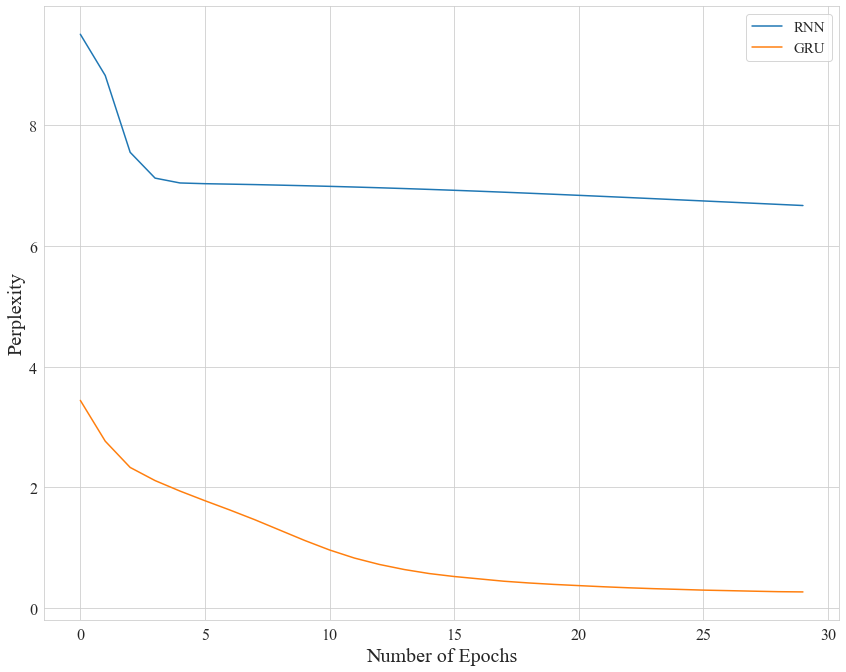

In [50]:
## Loss Graphs
plt.rc('font', family='Times New Roman', serif='Times')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('axes', labelsize=20)

fig, ax = plt.subplots()
fig.subplots_adjust(left=.15, bottom=-1.16, right=1.99, top=.97)

## edit the plot list here
plt.plot(range(args.epochs), ppl)
plt.plot(range(args.epochs), ppl_gru)

ax.set_ylabel('Perplexity')
ax.set_xlabel('Number of Epochs')
ax.legend(['RNN', 'GRU'],fontsize=15)
sns.set_style('whitegrid')

- - -

## Question - e

(e) Pick the best performing (lowest PPL score) model, and generate the text autoregressively given the following prompts.
> (1) ‘We are’ \
(2) ‘what’ \
(3) ‘You’ \
(4) ‘I tell you, friends’

### Changing parameters from GRU model

* for better text generator

In [73]:
class Args__:
    emb_size=256
    gru_size=1024
    seq_size=400
    bs=128
    epochs=30
    lr=0.001
    momentum = 0.9
    verbose='store_true'
    seed=710674

args__ = Args__()    

np.random.seed(args__.seed)
random.seed(args__.seed)
torch.manual_seed(args__.seed)

In [74]:
seq_len = args__.seq_size
batch = args__.bs

input_seqs = []
target_seqs = []

num_seqs = len(text_as_int) // (seq_len+1)

for i in range(num_seqs):
    seq = text_as_int[i:i+seq_len+1]
    input_seqs.append(np.array(seq[:-1]))
    target_seqs.append(np.array(seq[1:]))

In [75]:
input_seqs = np.array(input_seqs)
target_seqs = np.array(target_seqs)

In [76]:
input_seqs = input_seqs[:(len(input_seqs)//batch)*batch]
target_seqs = target_seqs[:(len(input_seqs)//batch)*batch]

In [77]:
def build_model_(batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocabu_size, args__.emb_size, batch_input_shape=(batch_size, None)),
        tf.keras.layers.GRU(args__.gru_size, return_sequences=True, stateful=True),
        tf.keras.layers.Dense(vocabu_size),
    ])
    model.build()
    return model

In [78]:
model_ = build_model_(batch)
model_.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (128, None, 256)          16640     
_________________________________________________________________
gru_8 (GRU)                  (128, None, 1024)         3938304   
_________________________________________________________________
dense_8 (Dense)              (128, None, 65)           66625     
Total params: 4,021,569
Trainable params: 4,021,569
Non-trainable params: 0
_________________________________________________________________


In [79]:
EPOCHS = args__.epochs

loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
model_.compile(optimizer='adam', loss=loss)

history_ = model_.fit(input_seqs, target_seqs, epochs=args__.epochs, batch_size=args__.bs)

Epoch 1/30
21/21 [==============================] - 199s 9s/step - loss: 3.9638
Epoch 2/30
21/21 [==============================] - 252s 12s/step - loss: 2.9803
Epoch 3/30
21/21 [==============================] - 302s 14s/step - loss: 2.4870
Epoch 4/30
21/21 [==============================] - 342s 16s/step - loss: 2.1995
Epoch 5/30
21/21 [==============================] - 355s 17s/step - loss: 1.9819
Epoch 6/30
21/21 [==============================] - 352s 17s/step - loss: 1.7379
Epoch 7/30
21/21 [==============================] - 357s 17s/step - loss: 1.3999
Epoch 8/30
21/21 [==============================] - 361s 17s/step - loss: 0.8995
Epoch 9/30
21/21 [==============================] - 360s 17s/step - loss: 0.3899
Epoch 10/30
21/21 [==============================] - 356s 17s/step - loss: 0.1599
Epoch 11/30
21/21 [==============================] - 358s 17s/step - loss: 0.1026
Epoch 12/30
21/21 [==============================] - 356s 17s/step - loss: 0.0835
Epoch 13/30
21/21 [=======

### Text generator model

In [80]:
generator_model = build_model(1)

for i in range(len(generator_model.layers)):
    for j in range(len(generator_model.layers[i].weights)):
        generator_model.layers[i].weights[j].assign(model.layers[i].weights[j])

In [81]:
def generate_texts(model, seed, out_len):

    text_generated = []
    model.reset_states()    
    inp = np.array([char2idx[s] for s in seed])

    for i in range(out_len):

        pred = model(inp[None, ...])[0]
        temperature = 1.0
        pred = pred / temperature
        pred_c = tf.random.categorical(pred, num_samples=1)[-1][0].numpy()        
        text_generated.append(idx2char[pred_c])        
        inp = np.array([pred_c])

    return (seed + ''.join(text_generated))

### Text  generation results

In [86]:
print(generate_texts(generator_model, seed=u"We are", out_len=400))

We are that
Congudimure us one honest is contented members, tue.

First Citizen:
I say inos,
With us accued head, to did,
What!
The kingly-crboursents and peate, whose courses com small you heade it, and ne'ere farain
the sufferann to
fort, but softly proud; whim for us!
What then?

First Citizen:
Should by the body, hid, Rotricions, my goots even to chore-ife o' the comande'd Citizen:
You are to thus d


In [87]:
print(generate_texts(generator_model, seed=u"what", out_len=400))

what malicco is to
vicians our borknous maltizen:
Would you proceed especimushe here theme would relias strucupetitiansw:
Thiture they with you know Caius Marand?

MENENIUS:
Either you must
Confess yourselves welly
Not umisenide his felpate, whose course wa bey,----ENENIUS:
Sither who good friends, migsort o' the body,--

MENENIUS:
Well, what then?

MENENIUS:
The other answer. What answer you must
Con


In [88]:
print(generate_texts(generator_model, seed=u"You", out_len=400))

You must here?

Second Citizen:
Nar: the peericusher? What then?

First Citizen:
The forme ard cupric, ne's a liting
survippainst Caiusly us
I not to kneed be course will on
The well y'uld-

First Citizen:
Consiely will as actid
it to taves as liot course will on
The wouslf our stoder stay we aminesell
Thity
Thither
The would Catue and he prover
suffers, nople.

All:
Searing thame they betain; the lo


In [89]:
print(generate_texts(generator_model, seed=u"I tell you, friends", out_len=400))

I tell you, friends, most thith as you. The pla;
would his delp, is for, not, what then? what!
The kingable; wale
it, and restrain
Strown prellicts, will you must, walle.

All:
No kink o' they has poor
suitors have strong breathous.

First Citizen:
Nay comes hithelf as we
bremand poor
surpomiends, my country?

First Citizen:
Very well; and supeconest ones: you morted members, nople.

All:
We know't, we kingly-crond 
